In [2]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cse455/assignments/assignment6'
FOLDERNAME = 'cse455/assignments/assignment6'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

%cd /content/drive/MyDrive/$FOLDERNAME


Mounted at /content/drive
/content/drive/MyDrive/cse455/assignments/assignment6


# Assignment 6 (Extra Credit)

In this notebook, you'll build from the ground up a pipeline for structure-from-motion. By the end, we will be able to reconstruct scenes displayed by a 3D pointcloud.

## 1. Fundamental Matrix

We begin this journey with estimating the fundamental matrix. In stereo vision, the fundamental matrix plays a crucial role in understanding the geometric relationship between two images of the same scene. Specifically, it gives us a compact description of how any single point seen in one image must appear in the second view.

Formally, for corresponding points $x$ in the first image and $x'$ in the second image (in homogenous coordinates), the epipolar constraint can be expressed as:
$$x'^T F x = 0$$
This constraint implies that the epipolar line corresponding to any point $x$ in the first image is given by $l' = Fx$, and similarly, the epipolar line for a point $x'$ in the second image is given by $l = F^Tx'$.

Your task for this section will be to implement two popular algorithms for estimating the fundamental matrix:
- Linear Least-Squares Eight Point Algorithm
- Normalized Eight-Point Algorithm

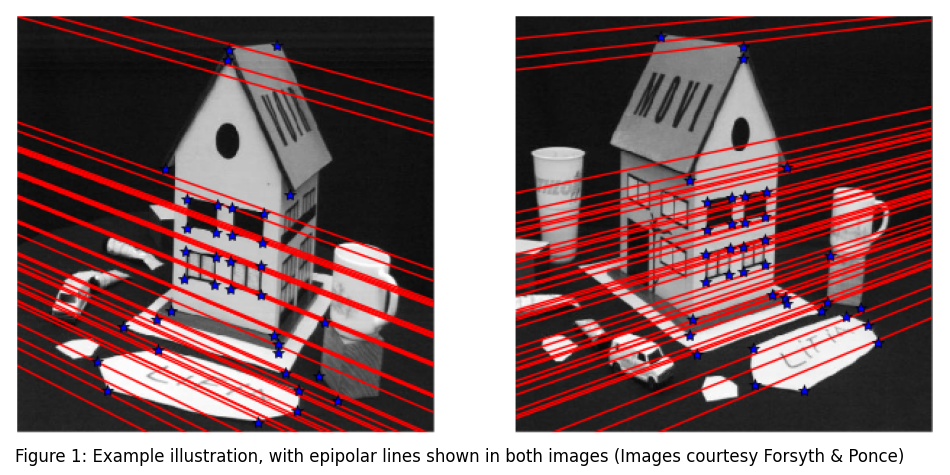

In [3]:
import matplotlib.pyplot as plt
from skimage.io import imread
import numpy as np
from epipolar_utils import *
from fundamental_matrix import lls_eight_point_alg, normalized_eight_point_alg, compute_distance_to_epipolar_lines, plot_epipolar_lines_on_images


img_path = 'figures/fund2.png'

img = imread(img_path)

fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(img)
ax.axis('off')

fig.text(0.5, 0.2,
         'Figure 1: Example illustration, with epipolar lines shown in both images (Images courtesy Forsyth & Ponce)',
         wrap=True, horizontalalignment='center', fontsize=12)

plt.show()


# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

### 1.1 Understanding The Fundamental Matrix
Let's try to understand this intuitively. Describe in a 2-3 sentences why $F$ must be a rank-2 matrix along with what each of the row/columns of F geometrically represent.

---

**Your response here:** Write your answer in this markdown cell.

F must be a rank 2 matrix because it is first derived from the 3 by 3 essential matrix, but it also maps one point in one image to a line in the other image that is called the epipolar line, and all epipolar lines in that second image go through one point called the epipoint; therefore, since all lines are forced into one point there is a substanial loss of information, which forces the rank to be limited.

The rows of F represesnt the epipolar lines in the first image that correspond to the basis vectors in the second, while the second image is the opposite - it matches the epipolar lines in the second image to the basis vectors in the first.

### 1.2. Linear Least-Squares Eight Point Algorithm

Implement a function to compute the fundamental matrix from matching points using the **Linear Least-Squares Eight-Point Algorithm (LLS)**.

Recall from lecture:
1. Form a matrix $A$ from the point correspondences.
2. Solve for $f$ (the elements of $F $) by minimizing $ \| A f \|^2 $ subject to $ \| f \| = 1 $.
3. Enforce rank-2 on $ F $ by performing an SVD on $ F $ and zeroing out the smallest singular value.

Implement `lls_eight_point_alg` in `fundamental_matrix.py`. Below we load sample images and harris corner point locations.

--------------------------------------------------------------------------------
Set: data/set1
--------------------------------------------------------------------------------
Fundamental Matrix (LLS 8-point):
 [[ 1.55218081e-06 -8.18161523e-06 -1.50440111e-03]
 [-5.86997052e-06 -3.02892219e-07 -1.13607605e-02]
 [-3.52312036e-03  1.41453881e-02  9.99828068e-01]]


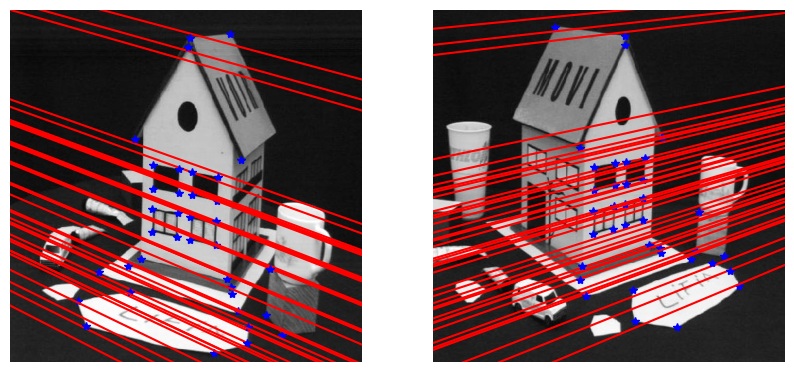

--------------------------------------------------------------------------------
Set: data/set2
--------------------------------------------------------------------------------
Fundamental Matrix (LLS 8-point):
 [[-5.63087200e-06  2.74976583e-05 -6.42650411e-03]
 [-2.77622828e-05 -6.74748522e-06  1.52182033e-02]
 [ 1.07623595e-02 -1.22519240e-02 -9.99730547e-01]]


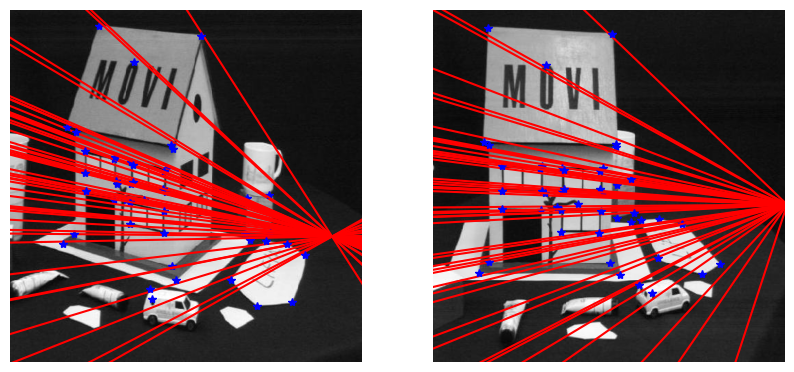

In [4]:
# Example sets
for im_set in ['data/set1', 'data/set2']:
  print('-'*80)
  print("Set:", im_set)
  print('-'*80)

  # 1. Read images
  im1 = imread(im_set + '/image1.jpg')
  im2 = imread(im_set + '/image2.jpg')

  F_lls_expected = np.zeros((3, 3))
  if im_set == 'data/set1':
    F_lls_expected =  [[ 1.55218081e-06, -8.18161523e-06, -1.50440111e-03],
                      [-5.86997052e-06, -3.02892219e-07, -1.13607605e-02],
                      [-3.52312036e-03,  1.41453881e-02,  9.99828068e-01]]
  else:
    F_lls_expected =  [[-5.63087200e-06,  2.74976583e-05, -6.42650411e-03],
                      [-2.77622828e-05, -6.74748522e-06,  1.52182033e-02],
                      [ 1.07623595e-02, -1.22519240e-02, -9.99730547e-01]]



  # 2. Load matched points
  points1 = get_data_from_txt_file(im_set + '/pt_2D_1.txt')
  points2 = get_data_from_txt_file(im_set + '/pt_2D_2.txt')
  assert (points1.shape == points2.shape)

  # 3. Linear 8-point
  F_lls = lls_eight_point_alg(points1, points2)
  print("Fundamental Matrix (LLS 8-point):\n", F_lls)

  assert np.max(np.abs(F_lls - F_lls_expected)) < 1e-7, "Your solution is not correct"

  # 4. Plot epipolar lines
  plot_epipolar_lines_on_images(points1, points2, im1, im2, F_lls)
  plt.show()

### 1.2 (continued)
Observe that the linear least-squares eight-point algorithm doesn’t always produce epipolar lines that pass through each point. This happens because image coordinates are large and unnormalized, so even small sensor noise or misalignments can lead to poor conditioning in the least-squares system. To address this, we turn to the normalized eight-point algorithm, which improves numerical stability by centering and scaling the input points.

### 1.3. Normalized Eight-Point Algorithm

Implement the **Normalized Eight-Point Algorithm**, which includes the additional normalization (pre-scaling) step to improve numerical stability:
1. Normalize (translate + scale) the input points $ (x,y) $ so that their centroid is at the origin and their average distance from the origin is $\sqrt{2}$.
2. Use the same linear approach as in the LLS eight-point algorithm to estimate the fundamental matrix in normalized coordinates.
3. Transform the resulting $ F $ back to the original coordinate system.

Implement `normalized_eight_point_alg` function in `fundamental_matrix.py`.

--------------------------------------------------------------------------------
Set: data/set1
--------------------------------------------------------------------------------
[[ 6.52113484e-07 -5.33615067e-06  8.80860210e-05]
 [-4.91237449e-06 -3.40420428e-07 -6.43807393e-03]
 [-8.56136054e-04  8.84208000e-03  1.45953063e-01]]
Max |p'^T F p| for normalized F = 0.030295853313209165
Fundamental Matrix (Normalized 8-point):
 [[ 6.52113484e-07 -5.33615067e-06  8.80860210e-05]
 [-4.91237449e-06 -3.40420428e-07 -6.43807393e-03]
 [-8.56136054e-04  8.84208000e-03  1.45953063e-01]]


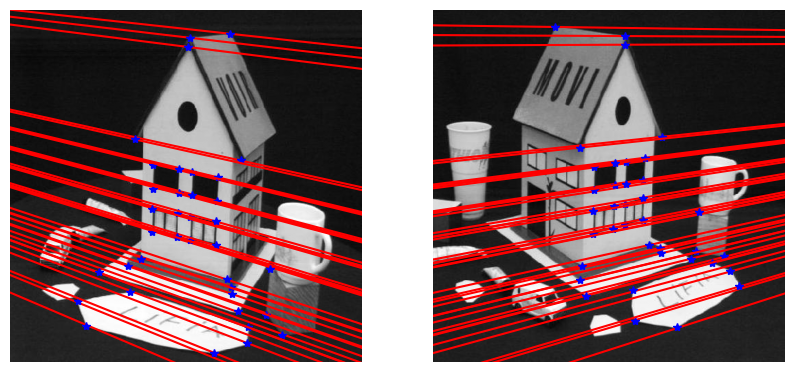

--------------------------------------------------------------------------------
Set: data/set2
--------------------------------------------------------------------------------
[[-1.51007608e-07  2.51618737e-06 -1.56134009e-04]
 [ 3.63462620e-06  3.22311660e-07  7.02588719e-03]
 [ 2.36155133e-04 -8.53003408e-03 -2.45880925e-03]]
Max |p'^T F p| for normalized F = 0.033136691062292556
Fundamental Matrix (Normalized 8-point):
 [[-1.51007608e-07  2.51618737e-06 -1.56134009e-04]
 [ 3.63462620e-06  3.22311660e-07  7.02588719e-03]
 [ 2.36155133e-04 -8.53003408e-03 -2.45880925e-03]]


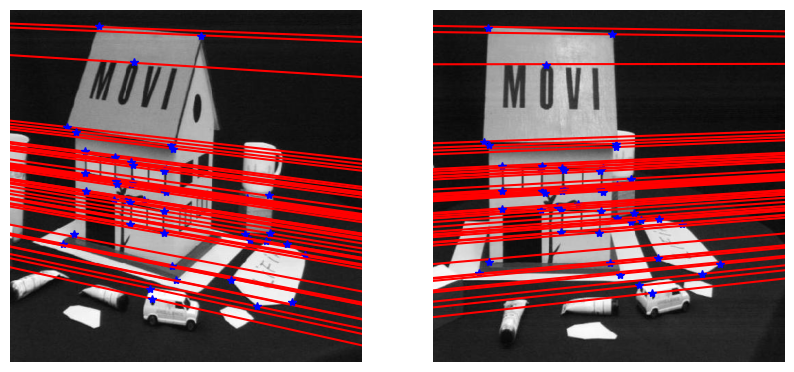

In [5]:
# Example sets
for im_set in ['data/set1', 'data/set2']:
  print('-'*80)
  print("Set:", im_set)
  print('-'*80)

  # 1. Read images
  im1 = imread(im_set + '/image1.jpg')
  im2 = imread(im_set + '/image2.jpg')

  F_norm_expected = np.zeros((3, 3))
  if im_set == 'data/set1':
    F_norm_expected =  [[ 6.52113484e-07, -5.33615067e-06,  8.80860210e-05],
                        [-4.91237449e-06, -3.40420428e-07, -6.43807393e-03],
                        [-8.56136054e-04,  8.84208000e-03,  1.45953063e-01]]
  else:
    F_norm_expected =  [[-1.51007608e-07,  2.51618737e-06, -1.56134009e-04],
                        [ 3.63462620e-06,  3.22311660e-07,  7.02588719e-03],
                        [ 2.36155133e-04, -8.53003408e-03, -2.45880925e-03]]


  # 2. Load matched points
  points1 = get_data_from_txt_file(im_set + '/pt_2D_1.txt')
  points2 = get_data_from_txt_file(im_set + '/pt_2D_2.txt')
  assert (points1.shape == points2.shape)

  # 3. Normalized 8-point
  F_norm = normalized_eight_point_alg(points1, points2)

  pFp = []
  for i in range(points1.shape[0]):
      val = points2[i].dot(F_norm.dot(points1[i]))
      pFp.append(val)
  print(F_norm)
  assert np.max(np.abs(F_norm - F_norm_expected)) < 1e-7, "Your solution is not correct"


  print("Max |p'^T F p| for normalized F =", np.abs(pFp).max())
  print("Fundamental Matrix (Normalized 8-point):\n", F_norm)

  # 4. Plot epipolar lines
  plot_epipolar_lines_on_images(points1, points2, im1, im2, F_norm)

  plt.show()

### 1.3 (continued)

Great! Now that you've implemented both linear and normalized eight-point algorithms, it's time to put them to the test.

### 1.4 Putting It Together

We have been given two datasets (`set1` and `set2`), each containing:
- A pair of images capturing the same scene from different viewpoints.
- A set of corresponding points between these two images.
- Our goal is to estimate the fundamental matrix $F\$ and verify how well it captures the epipolar constraint.

Once we estimate $ F $, we need a way to quantify its accuracy.  
A simple way to check correctness is by computing the distance of each matched point to its corresponding epipolar line.

Given a point $ x = (x, y, 1)^T $ in one image, its epipolar line in the other image is:
$$
l' = F x
$$
which means any corresponding point $ x' $ should satisfy:
$$
x'^T F x = 0.
$$
However, due to noise, this equation may not hold exactly. Instead, we measure how far $ x' $ is from its epipolar line $ l' $ using the formula:

$$
d = \frac{|a x + b y + c|}{\sqrt{a^2 + b^2}}
$$

where $ a, b, c $ are the coefficients of the epipolar line $ l' $.  

This gives the shortest distance from the point to the line, and we compute the average distance across all points as a metric of correctness.

Implement `compute_distance_to_epipolar_lines()` in `fundamental_matrix.py` to compute the average epipolar distance for a given set of matched points and $ F $.


--------------------------------------------------------------------------------
Set: data/set1
--------------------------------------------------------------------------------
Distance to lines in image 1 (LLS): 28.025662937574687
Distance to lines in image 2 (LLS): 25.162875800069568
Distance to lines in image 1 (norm): 0.8906416272438076
Distance to lines in image 2 (norm): 0.8287729118221303


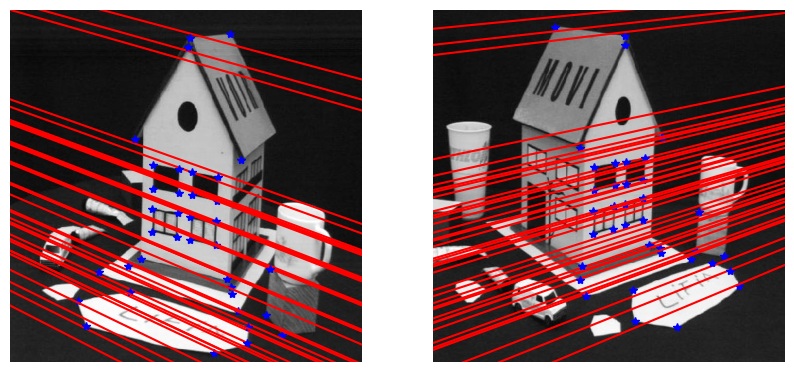

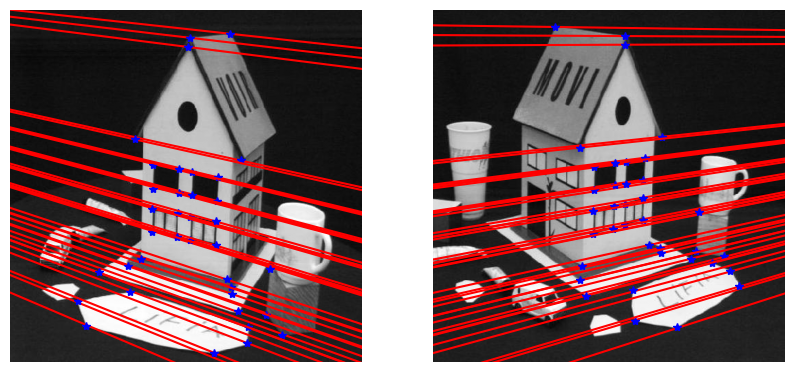

--------------------------------------------------------------------------------
Set: data/set2
--------------------------------------------------------------------------------
Distance to lines in image 1 (LLS): 9.701438829446099
Distance to lines in image 2 (LLS): 14.568227190516716
Distance to lines in image 1 (norm): 0.8895134540568871
Distance to lines in image 2 (norm): 0.8917343723800223


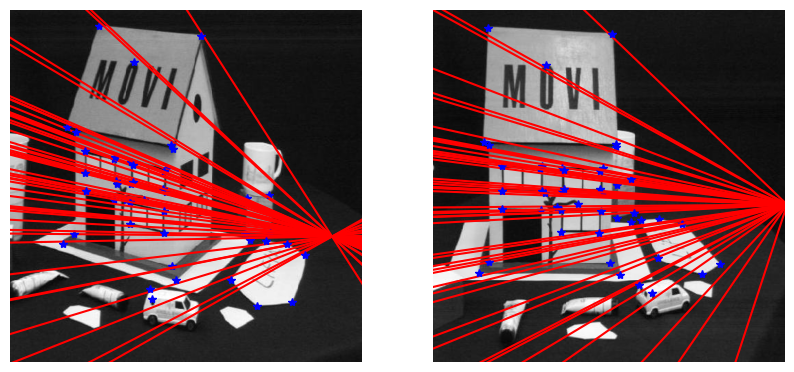

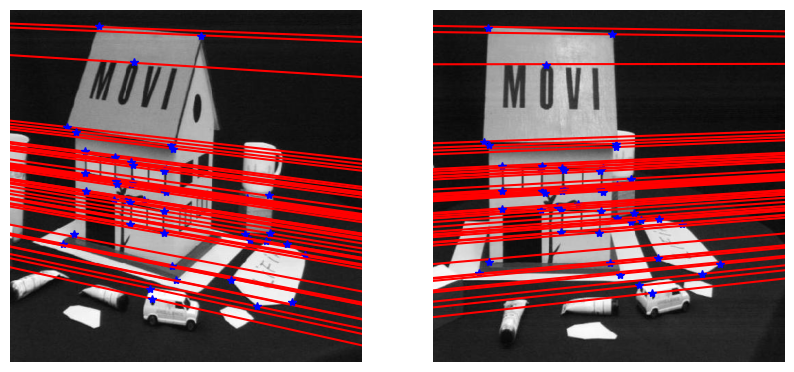

In [7]:
from fundamental_matrix import lls_eight_point_alg, normalized_eight_point_alg, compute_distance_to_epipolar_lines, plot_epipolar_lines_on_images

# Example sets
for im_set in ['data/set1', 'data/set2']:
    print('-'*80)
    print("Set:", im_set)
    print('-'*80)

    # 1. Read images
    im1 = imread(im_set + '/image1.jpg')
    im2 = imread(im_set + '/image2.jpg')

    # 2. Load matched points
    points1 = get_data_from_txt_file(im_set + '/pt_2D_1.txt')
    points2 = get_data_from_txt_file(im_set + '/pt_2D_2.txt')
    assert (points1.shape == points2.shape)

    # 3. Linear 8-point
    F_lls = lls_eight_point_alg(points1, points2)
    # print("Fundamental Matrix (LLS 8-point):\n", F_lls)
    print("Distance to lines in image 1 (LLS):",
          compute_distance_to_epipolar_lines(points1, points2, F_lls))
    print("Distance to lines in image 2 (LLS):",
          compute_distance_to_epipolar_lines(points2, points1, F_lls.T))

    # 4. Normalized 8-point
    F_norm = normalized_eight_point_alg(points1, points2)

    pFp = []
    for i in range(points1.shape[0]):
        val = points2[i].dot(F_norm.dot(points1[i]))
        pFp.append(val)

    print("Distance to lines in image 1 (norm):",
          compute_distance_to_epipolar_lines(points1, points2, F_norm))
    print("Distance to lines in image 2 (norm):",
          compute_distance_to_epipolar_lines(points2, points1, F_norm.T))

    # 5. Plot epipolar lines
    plot_epipolar_lines_on_images(points1, points2, im1, im2, F_lls)
    plot_epipolar_lines_on_images(points1, points2, im1, im2, F_norm)

    plt.show()

## 2. Matching Homographies for Image Rectification

After estimating $F$ we know that every true match must lie on its epipolar line, so in theory we only have to scan a 1D line to find the correspondence.

But... note how each epipolar line is slanted at a different angle! Wouldn't it be nice if they were all horizontal so we could just scan a single row? Rectification achieves exactly that: by warping both images with a pair of projective transforms (homographies) $H_1$ and $H_2$, we push the epipoles to infinity along the x-axis, which forces all epipolar lines to become parallel to the horizontal axis. Once rectified, dense stereo reduces to a simple left–right disparity search and depth falls out via $Z = fB/d$ where $B$ is the distance between the two camera centers (B), $f$ is the focal length, $d$ is the disparity ($x_{left} - x_{right}$), and $Z$ is the depth of the 3D point.

Implement `compute_epipole()`, `compute_H()`, and `compute_matching_homographies()` in `image_rectification.py`.

e1 [1.65412463e+03 4.53021078e+01 1.00000000e+00]
e2 [-1.30071143e+03 -1.42448272e+02  1.00000000e+00]
H1:
 [[ 1.          0.          0.        ]
 [ 0.55255957 -0.74053908 69.37265625]
 [ 0.          0.          1.        ]]
H2:
 [[-9.68769859e-01 -2.47961612e-01  3.11483257e+02]
 [ 2.47961612e-01 -9.68769859e-01  1.84526911e+02]
 [ 6.02883117e-04  1.54311025e-04  8.06158300e-01]]


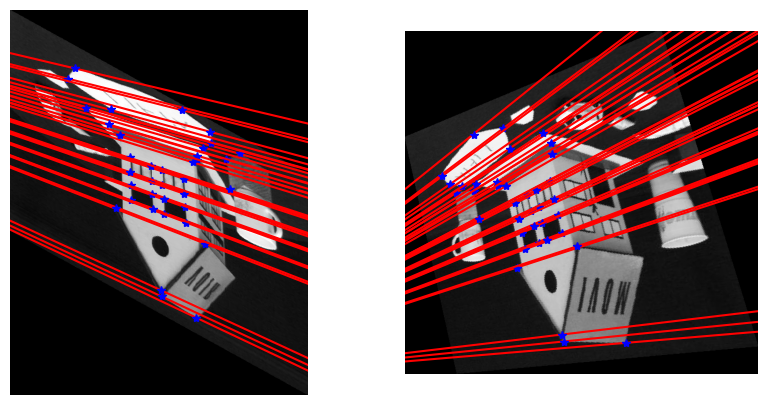

In [9]:
from fundamental_matrix import *
from image_rectification import *
# Read in the data
im_set = 'data/set1'
im1 = imread(im_set+'/image1.jpg')
im2 = imread(im_set+'/image2.jpg')
points1 = get_data_from_txt_file(im_set+'/pt_2D_1.txt')
points2 = get_data_from_txt_file(im_set+'/pt_2D_2.txt')
assert (points1.shape == points2.shape)

F = normalized_eight_point_alg(points1, points2)
e1 = compute_epipole(points1, points2, F)
e2 = compute_epipole(points2, points1, F.transpose())

print("e1", e1)
print("e2", e2)

# Find the homographies needed to rectify the pair of images
H1, H2 = compute_matching_homographies(e2, F, im2, points1, points2)
print("H1:\n", H1)
print
print("H2:\n", H2)

# Transforming the images by the homographies
new_points1 = H1.dot(points1.T)
new_points2 = H2.dot(points2.T)
new_points1 /= new_points1[2,:]
new_points2 /= new_points2[2,:]
new_points1 = new_points1.T
new_points2 = new_points2.T
rectified_im1, offset1 = compute_rectified_image(im1, H1)
rectified_im2, offset2 = compute_rectified_image(im2, H2)
new_points1 -= offset1 + (0,)
new_points2 -= offset2 + (0,)

# Plotting the image
F_new = normalized_eight_point_alg(new_points1, new_points2)
plot_epipolar_lines_on_images(new_points1, new_points2, rectified_im1, rectified_im2, F_new)
plt.show()

## 3. Structure from Motion

Up to this point we have focused on a *single* stereo pair:  
we detected correspondences $\{\mathbf{x}_i \leftrightarrow \mathbf{x}'_i\}$, estimated the fundamental matrix $F$, and (optionally) rectified the two images to simplify matching.  
The next step is to **scale this idea to many views**.

Given a sequence of images $ \{I_1, I_2, \dots, I_N\} $ in which the same scene is observed from varying poses, we wish to recover

- the $3\times4$ **camera matrix** for each view  
  $$
  P_k \;=\; K_k \,[\,R_k \;|\; \mathbf{t}_k\,],
  $$
- and a consistent 3-D point cloud $\{\mathbf{X}_j\}$ such that  
  $$
  \mathbf{x}_{j,k} \;=\; P_k\,\mathbf{X}_j
  \qquad\text{for all visible pairs }(j,k).
  $$

This global recovery process is called **Structure-from-Motion (SfM)**.  
In the code that follows you will:

1. **Estimate an essential matrix** $E$ from calibrated correspondences and decompose it into the four candidate $(R,\mathbf{t})$ pairs.  
2. **Triangulate** matches to obtain an initial 3-D structure.  
3. **Disambiguate** the correct $(R,\mathbf{t})$ by enforcing that all triangulated points lie in front of both cameras.  
4. **Refine *all* camera poses and 3-D points** with bundle adjustment to minimise total reprojection error.

By the end of this section you will turn nothing but pixel coordinates into a metrically correct, rotated 3-D model of the statue scene and be able to visualise it from any angle.

---

### What you will implement in `triangulation.py`

> **Heads-up:** this file is the engine room of the SfM pipeline, which is why finishing it yields **75\% of the extra-credit for this assignment**.

<table>
  <thead>
    <tr>
      <th>Function</th>
      <th>Purpose</th>
      <th>Key math</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><code>estimate_initial_RT(E)</code></td>
      <td>Decompose the essential matrix into the four candidate camera motions and pick the physically valid one.</td>
      <td>$\text{SVD of } E$; cheirality check.</td>
    </tr>
    <tr>
      <td><code>linear_estimate_3d_point(matches, P)</code></td>
      <td>Closed-form triangulation of a single point from two views.</td>
      <td>DLT least-squares solve.</td>
    </tr>
    <tr>
      <td><code>reprojection_error(X, matches, P)</code></td>
      <td>Compute residuals $\mathbf{x} - \hat{\mathbf{x}}$ for bundle adjustment.</td>
      <td>$\hat{\mathbf{x}} = P \mathbf{X}$</td>
    </tr>
    <tr>
      <td><code>jacobian(X, P)</code></td>
      <td>Analytical Jacobian of the reprojection error w.r.t. $X$.</td>
      <td>Partial derivatives of homogeneous projection.</td>
    </tr>
    <tr>
      <td><code>nonlinear_estimate_3d_point(matches, P)</code></td>
      <td>Refine a point with Levenberg–Marquardt using the error &amp; Jacobian above.</td>
      <td>Gauss–Newton iterations.</td>
    </tr>
  </tbody>
</table>



In [10]:
# Setup for SFM

import os
from triangulation import *
# from sfm_utils import Frame
from sfm_utils import *
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

run_pipeline = True

# Load the data
image_data_dir = 'data/statue/'
unit_test_camera_matrix = np.load('data/unit_test_camera_matrix.npy')
unit_test_image_matches = np.load('data/unit_test_image_matches.npy')
image_paths = [os.path.join(image_data_dir, 'images', x) for x in
    sorted(os.listdir('data/statue/images')) if '.jpg' in x]
focal_length = 719.5459
matches_subset = np.load(os.path.join(image_data_dir,
    'matches_subset.npy'), allow_pickle=True, encoding='latin1')[0,:]
dense_matches = np.load(os.path.join(image_data_dir, 'dense_matches.npy'),
                            allow_pickle=True, encoding='latin1')
fundamental_matrices = np.load(os.path.join(image_data_dir,
    'fundamental_matrices.npy'), allow_pickle=True, encoding='latin1')[0,:]

<ipython-input-10-6cd3f7b2eaaf>:15: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  unit_test_camera_matrix = np.load('data/unit_test_camera_matrix.npy')
<ipython-input-10-6cd3f7b2eaaf>:16: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  unit_test_image_matches = np.load('data/unit_test_image_matches.npy')
<ipython-input-10-6cd3f7b2eaaf>:22: UserWarning: Reading `.npy` or `.npz` file required additional header parsing as it was created on Python 2. Save the file again to speed up loading and avoid this warning.
  dense_matches = np.load(os.path.join(image_data_dir, 'dense_matches.npy'),


### Part A: Initial Camera Motion from Essential Matrix

Given an essential matrix `E`, we know the relative rotation and translation between two calibrated cameras is encoded in it. But there are **four possible [R|t] decompositions**—only one of which places the triangulated 3D points in front of both cameras. This is because there are two options one could obtain from SVD of $E$ for both $R$ and $T$.

Implement `estimate_initial_RT(E)` to:
- Compute the four candidate `[R|t]` matrices using the **SVD decomposition** of `E`.
- Generate the two valid rotation matrices from `U`, `W`, and `Vᵀ`.
- Generate two translation vectors from the third column of `U`.
- Stack all four combinations into a `4x3x4` array.

This function gives us the physical camera pose options, but selecting the right one comes later.


In [12]:
# Part A: Computing the 4 initial R,T transformations from Essential Matrix
print('-' * 80)
print("Part A: Check your matrices against the example R,T")
print('-' * 80)
K = np.eye(3)
K[0,0] = K[1,1] = focal_length
E = K.T.dot(fundamental_matrices[0]).dot(K)
im0 = imread(image_paths[0])
im_height, im_width, _ = im0.shape
example_RT = np.array([[0.9736, -0.0988, -0.2056, 0.9994],
    [0.1019, 0.9948, 0.0045, -0.0089],
    [0.2041, -0.0254, 0.9786, 0.0331]])
print("Example RT:\n", example_RT)
estimated_RT = estimate_initial_RT(E)
print('')
print("Estimated RT:\n", estimated_RT)

--------------------------------------------------------------------------------
Part A: Check your matrices against the example R,T
--------------------------------------------------------------------------------
Example RT:
 [[ 0.9736 -0.0988 -0.2056  0.9994]
 [ 0.1019  0.9948  0.0045 -0.0089]
 [ 0.2041 -0.0254  0.9786  0.0331]]

Estimated RT:
 [[[ 0.98305251 -0.11787055 -0.14040758  0.99941228]
  [-0.11925737 -0.99286228 -0.00147453 -0.00886961]
  [-0.13923158  0.01819418 -0.99009269  0.03311219]]

 [[ 0.98305251 -0.11787055 -0.14040758 -0.99941228]
  [-0.11925737 -0.99286228 -0.00147453  0.00886961]
  [-0.13923158  0.01819418 -0.99009269 -0.03311219]]

 [[ 0.97364135 -0.09878708 -0.20558119  0.99941228]
  [ 0.10189204  0.99478508  0.00454512 -0.00886961]
  [ 0.2040601  -0.02537241  0.97862951  0.03311219]]

 [[ 0.97364135 -0.09878708 -0.20558119 -0.99941228]
  [ 0.10189204  0.99478508  0.00454512  0.00886961]
  [ 0.2040601  -0.02537241  0.97862951 -0.03311219]]]


### Part B: Linear Triangulation

Once we know the projection matrices for two views and the corresponding image coordinates of a point, we can solve for the 3D location of that point using a simple linear system.

Implement `linear_estimate_3d_point` to:
- Set up the linear system $( A \mathbf{X} = 0 )$ using the projection equations from two or more cameras.
- Stack two equations per camera from the cross-product constraint.
- Solve the system using **SVD**, and normalize the result to get a Euclidean 3D point.

This will give you a first estimate of the 3D point that you'll refine later.


In [16]:
# Part B: Determining the best linear estimate of a 3D point
print('-' * 80)
print('Part B: Check that the difference from expected point ')
print('is near zero')
print('-' * 80)
camera_matrices = np.zeros((2, 3, 4))
camera_matrices[0, :, :] = K.dot(np.hstack((np.eye(3), np.zeros((3,1)))))
camera_matrices[1, :, :] = K.dot(example_RT)
unit_test_matches = matches_subset[0][:,0].reshape(2,2)
estimated_3d_point = linear_estimate_3d_point(unit_test_matches.copy(),
    camera_matrices.copy())
expected_3d_point = np.array([0.6774, -1.1029, 4.6621])
print("Difference: ", np.fabs(estimated_3d_point - expected_3d_point).sum())
assert np.fabs(estimated_3d_point - expected_3d_point).sum() < 0.005, "Fail part B"

--------------------------------------------------------------------------------
Part B: Check that the difference from expected point 
is near zero
--------------------------------------------------------------------------------
Difference:  0.0029243053036643873


### Part C: Reprojection Error and Jacobian

To optimize a 3D point later, we need to understand how far off our current guess is (reprojection error), and how that error changes with respect to small changes in the point (Jacobian).

Implement:
- `reprojection_error` to:
  - Project the 3D point using each camera matrix.
  - Normalize homogeneous coordinates.
  - Compute the 2D difference between projected and observed image points.

- `jacobian` to:
  - Compute the analytical partial derivatives of the projection equations w.r.t. the 3D point.
  - Fill in a \( 2M \times 3 \) Jacobian matrix.

These two functions are essential for nonlinear optimization in Part D.


In [18]:
# Part C: Calculating the reprojection error and its Jacobian
print('-' * 80)
print('Part C: Check that the difference from expected error/Jacobian ')
print('is near zero')
print('-' * 80)
estimated_error = reprojection_error(
        expected_3d_point, unit_test_matches, camera_matrices)
estimated_jacobian = jacobian(expected_3d_point, camera_matrices)
expected_error = np.array((-0.0095458, -0.5171407,  0.0059307,  0.501631))
print("Error Difference: ", np.fabs(estimated_error - expected_error).sum())
assert np.fabs(estimated_error - expected_error).sum() < 1e6, "Fail part C"

expected_jacobian = np.array([[ 154.33943931, 0., -22.42541691],
      [0., 154.33943931, 36.51165089],
      [141.87950588, -14.27738422, -56.20341644],
      [21.9792766, 149.50628901, 32.23425643]])
print("Jacobian Difference: ", np.fabs(estimated_jacobian
    - expected_jacobian).sum())
assert np.fabs(estimated_jacobian - expected_jacobian).sum() < 1e-6, "Fail part C"

--------------------------------------------------------------------------------
Part C: Check that the difference from expected error/Jacobian 
is near zero
--------------------------------------------------------------------------------
Error Difference:  8.301300130674275e-07
Jacobian Difference:  1.817115702351657e-08


### Part D: Nonlinear Triangulation of a 3D Point

Linear triangulation gives a quick estimate of a 3D point from multiple views, but it doesn’t always minimize reprojection error—especially when there’s noise in the image points. We can improve accuracy by refining the estimate through nonlinear optimization.

This function uses an iterative **Gauss–Newton** update to reduce reprojection error.

Implement `nonlinear_estimate_3d_point(image_points, camera_matrices)`:
- Start by computing a 3D point estimate using your `linear_estimate_3d_point()` function.
- For a fixed number of iterations (e.g., 10):
  - Compute the **reprojection error** between the current 3D estimate and the observed 2D image points using `reprojection_error()`.
  - Compute the **Jacobian** of that error using `jacobian()`.
  - Update the point with:
  $$
  \mathbf{X}_{\text{new}} = \mathbf{X}_{\text{old}} - (J^\top J)^{-1} J^\top \mathbf{e}
  $$
- Return the final optimized 3D point.

This refined estimate will have **lower reprojection error** than the linear one, and is critical for accurate dense 3D reconstruction in the later parts of the pipeline.


In [22]:
# Part D: Determining the best nonlinear estimate of a 3D point
print('-' * 80)
print('Part D: Check that the reprojection error from nonlinear method')
print('is lower than linear method')
print('-' * 80)
estimated_3d_point_linear = linear_estimate_3d_point(
    unit_test_image_matches.copy(), unit_test_camera_matrix.copy())
estimated_3d_point_nonlinear = nonlinear_estimate_3d_point(
    unit_test_image_matches.copy(), unit_test_camera_matrix.copy())
error_linear = reprojection_error(
    estimated_3d_point_linear, unit_test_image_matches,
    unit_test_camera_matrix)
print("Linear method error:", np.linalg.norm(error_linear))
error_nonlinear = reprojection_error(
    estimated_3d_point_nonlinear, unit_test_image_matches,
    unit_test_camera_matrix)
print("Nonlinear method error:", np.linalg.norm(error_nonlinear))
assert np.linalg.norm(error_linear) > np.linalg.norm(error_nonlinear), "Fail part D"

--------------------------------------------------------------------------------
Part D: Check that the reprojection error from nonlinear method
is lower than linear method
--------------------------------------------------------------------------------
Linear method error: 98.7354235689419
Nonlinear method error: 95.59481784846034


### Part E: Disambiguate the Correct Camera Pose from Essential Matrix

Once we have the essential matrix `E`, we can decompose it into four possible relative camera poses `[R|t]`. But which one is correct? The answer: the one that places **most 3D points in front of both cameras**.

In this part, you’ll use multiple point correspondences between the two images to disambiguate the correct pose.

Implement `estimate_RT_from_E(E, image_points, K)` to:

- Compute the four candidate `[R|t]` transformations using your `estimate_initial_RT()` function.
- For each candidate pose:
  - Construct camera matrices using `K`.
  - Triangulate each point using your `nonlinear_estimate_3d_point()`.
  - Count how many points have **positive depth** (i.e., are in front of both cameras).
- Return the `[R|t]` that gives the highest number of points in front of both cameras.

Once this is implemented correctly, your SfM pipeline will be able to reliably identify the second camera's position and orientation from real-world image correspondences.


In [27]:
# Part E: Determining the correct R, T from Essential Matrix
print('-' * 80)
print("Part E: Check your matrix against the example R,T")
print('-' * 80)
estimated_RT = estimate_RT_from_E(E,
    np.expand_dims(unit_test_image_matches[:2,:], axis=0), K)
print("Example RT:\n", example_RT)
print('')
print("Estimated RT:\n", estimated_RT)

--------------------------------------------------------------------------------
Part E: Check your matrix against the example R,T
--------------------------------------------------------------------------------
Example RT:
 [[ 0.9736 -0.0988 -0.2056  0.9994]
 [ 0.1019  0.9948  0.0045 -0.0089]
 [ 0.2041 -0.0254  0.9786  0.0331]]

Estimated RT:
 [[ 0.97364135 -0.09878708 -0.20558119  0.99941228]
 [ 0.10189204  0.99478508  0.00454512 -0.00886961]
 [ 0.2040601  -0.02537241  0.97862951  0.03311219]]


###Part F: Run the Full SfM Pipeline
Once all the pieces are working, it’s time to build a complete model of the scene.

Run the following cell and you should see how we triangulate points across all image pairs using your nonlinear estimator.

Once the cell finishes running (it might take a few minutes), it should visualize the dense 3D reconstruction.

All of this is driven through the code provided in the notebook, but relies on the accuracy of your implementations above.



--------------------------------------------------------------------------------
Part F: Run the entire SFM pipeline
--------------------------------------------------------------------------------


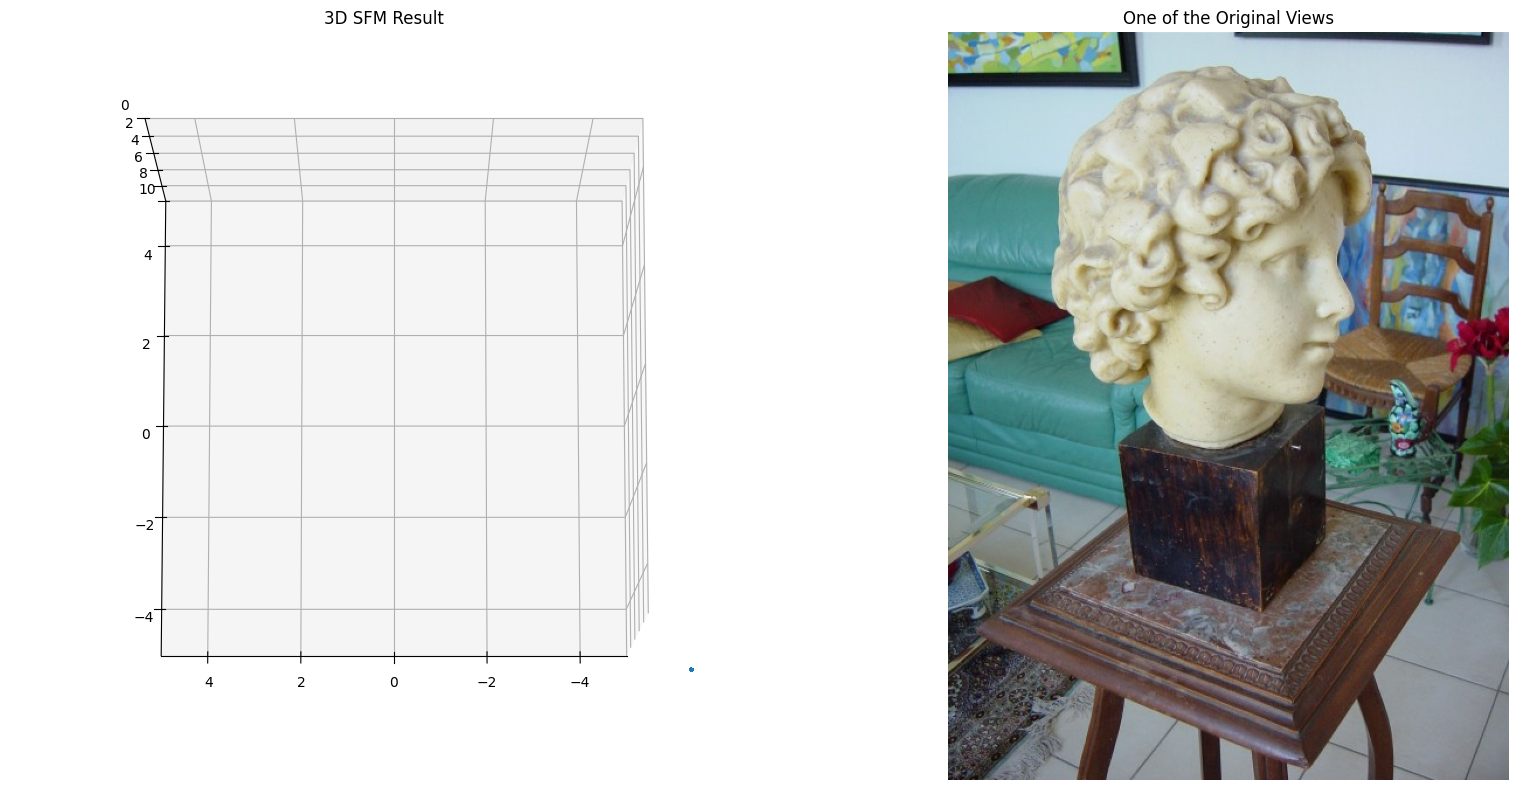

In [28]:
# Part F: Run the entire Structure from Motion pipeline
if not run_pipeline:
    sys.exit()
print('-' * 80)
print('Part F: Run the entire SFM pipeline')
print('-' * 80)
frames = [0] * (len(image_paths) - 1)
for i in range(len(image_paths)-1):
    frames[i] = Frame(matches_subset[i].T, focal_length,
            fundamental_matrices[i], im_width, im_height)
    bundle_adjustment(frames[i])
merged_frame = merge_all_frames(frames)

# Construct the dense matching
camera_matrices = np.zeros((2,3,4))
dense_structure = np.zeros((0,3))
for i in range(len(frames)-1):
    matches = dense_matches[i]
    camera_matrices[0,:,:] = merged_frame.K.dot(
        merged_frame.motion[i,:,:])
    camera_matrices[1,:,:] = merged_frame.K.dot(
            merged_frame.motion[i+1,:,:])
    points_3d = np.zeros((matches.shape[1], 3))
    use_point = np.array([True]*matches.shape[1])
    for j in range(matches.shape[1]):
        points_3d[j,:] = nonlinear_estimate_3d_point(
            matches[:,j].reshape((2,2)), camera_matrices)
    dense_structure = np.vstack((dense_structure, points_3d[use_point,:]))

# Load image
img_path = './data/statue/images/B21.jpg'
img = mpimg.imread(img_path)

# Create side-by-side subplots
fig = plt.figure(figsize=(18, 8))

# Left: 3D SFM plot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.scatter(dense_structure[:, 0], dense_structure[:, 1], dense_structure[:, 2],
            depthshade=True, s=2)
ax1.set_xlim(-5, 5)
ax1.set_ylim(-5, 5)
ax1.set_zlim(0, 10)
ax1.view_init(-100, 90)
ax1.set_title("3D SFM Result")

# Right: Original image
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(img)
ax2.axis('off')
ax2.set_title("One of the Original Views")

plt.tight_layout()
plt.show()